In [1]:
import ect
import cv2
import matplotlib.pyplot as plt
import numpy as np

from typing import Callable

radius = 200
img_offset = radius/20
ect_offset = radius/10

In [2]:
def rms(x: np.ndarray) -> float:
    rms_ = np.sqrt((x*np.conj(x)).sum().sum())
    return rms_

def rmsnorm(x: np.ndarray) -> np.ndarray:
    rms = np.sqrt((x*np.conj(x)).sum().sum())
    return x/rms

def absnorm(x):
    rms = np.sqrt((x*np.conj(x)).sum().sum())
    return np.abs(x)/rms

def snr(image: cv2.Mat, template: cv2.Mat):
    snr_lin = (1/rms((rmsnorm(image) - rmsnorm(template))))
    return 20*np.log10(snr_lin)

def snr_abs(image, template):
    abs_img = np.abs(rmsnorm(image))
    abs_temp = np.abs(rmsnorm(template))

    snr_ = (1/rms(abs_img - abs_temp))
    return 20*np.log10(snr_)

In [3]:
class ECTEvaluator:

    def __init__(
        self,
        img_path: str) -> None:
        
        src = cv2.imread(img_path)
        src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

        self.r = radius
        self.a = img_offset
        self.b = ect_offset

        self.img = ect.logpolar(src, self.r, offset=self.a)

        sidelobe = ect.sidelobe(self.img.shape[:2], offset=self.a)

        self.img = self.img * sidelobe
        self.inv = None


    def transform(self):

        dsize = self.img.shape[:2]

        snf = ect.spacenorm(dsize, self.r)
        fnf = ect.freqnorm(dsize, self.r)
        ang = ect.angular_filter(dsize)

        ect_img = ect.fect(self.img, self.a, self.b)
        ect_img = fnf * ect_img
        self.inv = ect.ifect(ect_img, self.a, self.b)
        self.inv = snf * ang * self.inv

        return self.inv


    def eval(self, eval_func: Callable[[np.ndarray, np.ndarray], float]):

        if self.inv is None:
            self.inv = self.transform()

        result = eval_func(self.img, self.inv)

        print(f"{eval_func.__name__} = {result:.2f}")

    def show(
        self,
        norm_fcn: Callable[[np.ndarray], np.ndarray],
        *params
        ):

        if self.inv is None:
            self.inv = self.transform()

        log_img = norm_fcn(self.img)
        inv_img = norm_fcn(self.inv)

        diff = log_img - inv_img

        plt.figure(figsize = (20, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(ect.complex_to_hsv(self.img))

        plt.subplot(1, 3, 2)
        plt.imshow(ect.complex_to_hsv(inv_img))

        plt.subplot(1, 3, 3)
        plt.imshow(ect.complex_to_hsv(diff))


    def show_cart(
        self,
        norm_fcn: Callable[[np.ndarray], np.ndarray],
        *params
    ):
        
        if self.inv is None:
            self.inv = self.transform()

        
        log_img = norm_fcn(self.img)
        inv_img = norm_fcn(self.inv)

        diff = ect.complex_to_hsv(log_img - inv_img)
        log_img = ect.complex_to_hsv(log_img)
        inv_img = ect.complex_to_hsv(inv_img)

        diff_cart = ect.ilogpolar(diff, radius = self.r, offset=self.a)
        src_cart = ect.ilogpolar(log_img, radius = self.r, offset=self.a)
        inv_cart = ect.ilogpolar(inv_img, radius = self.r, offset=self.a)

        plt.figure(figsize = (20, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(src_cart)

        plt.subplot(1, 3, 2)
        plt.imshow(inv_cart)

        plt.subplot(1, 3, 3)
        plt.imshow(diff_cart)


snr_abs = 29.75
snr = 28.09+0.00j


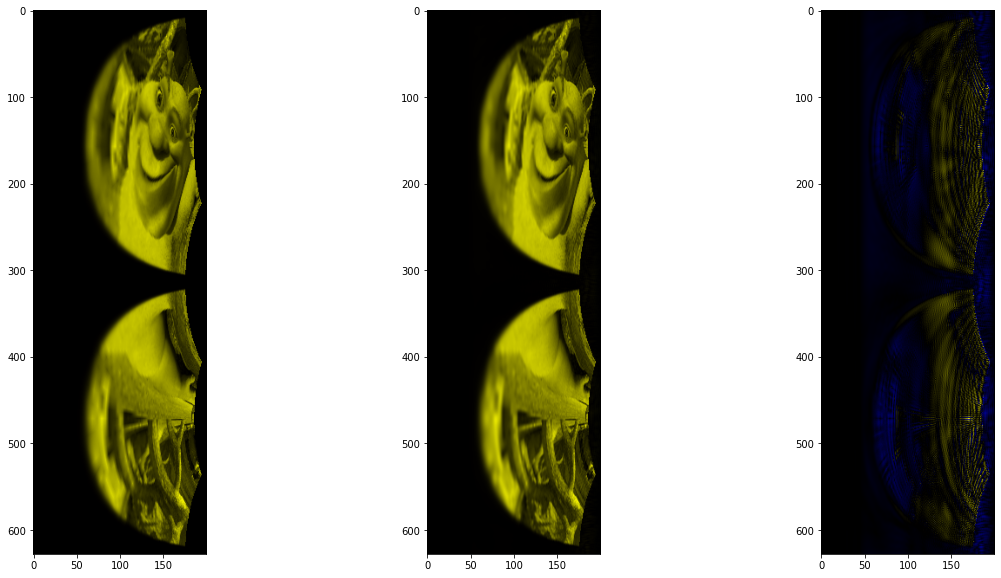

In [4]:
shrek = ECTEvaluator("../sample_imgs/shrek.png")

shrek.eval(snr_abs)
shrek.eval(snr)
shrek.show(absnorm)

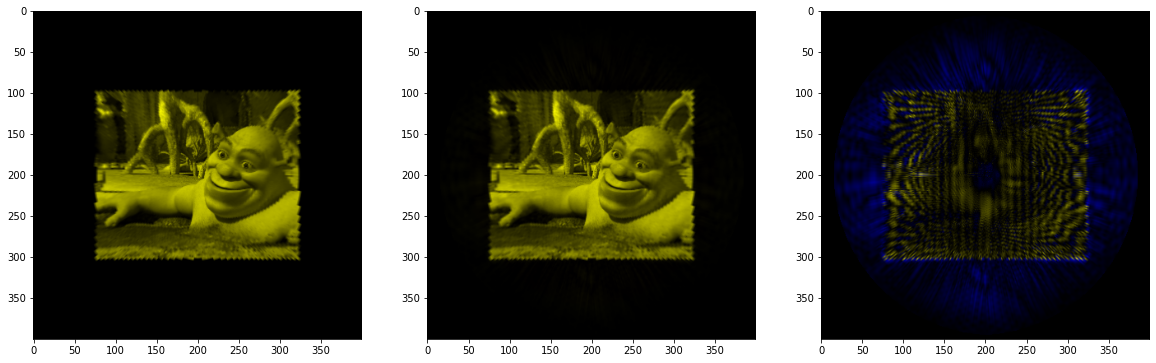

In [5]:
shrek.show_cart(absnorm)

snr = 20.36+0.00j
snr_abs = 21.28


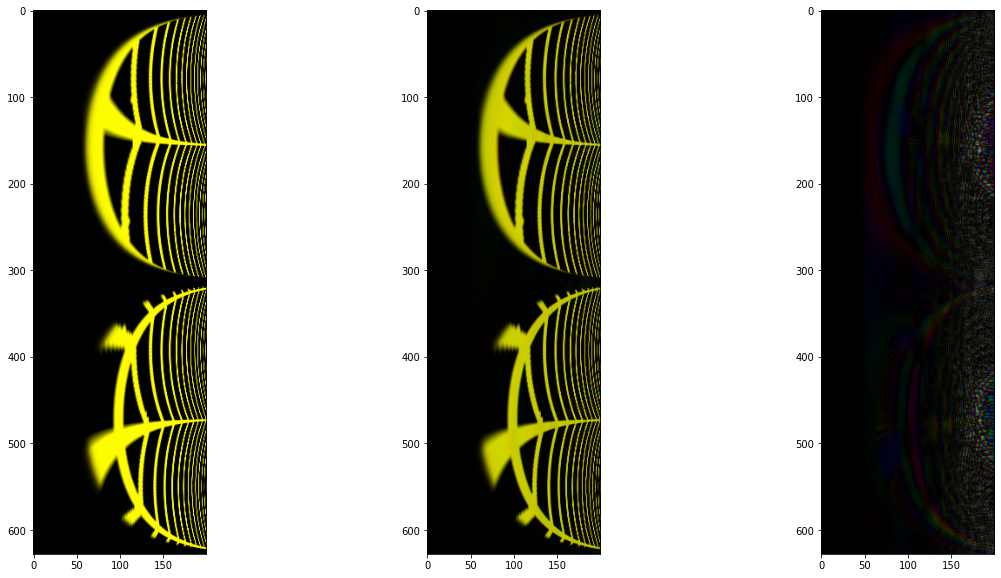

In [6]:
ruler = ECTEvaluator("../sample_imgs/ruler.png")

ruler.eval(snr)
ruler.eval(snr_abs)
ruler.show(rmsnorm)

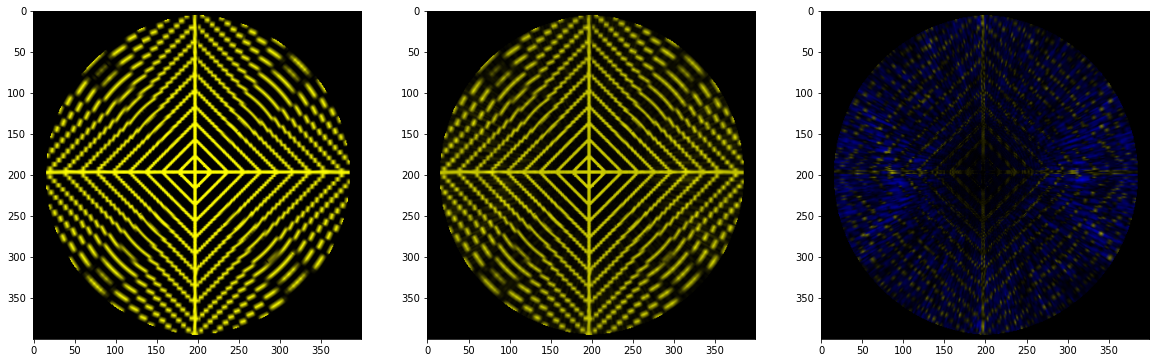

In [7]:
ruler.show_cart(absnorm)

snr = 26.91+0.00j
snr_abs = 28.14


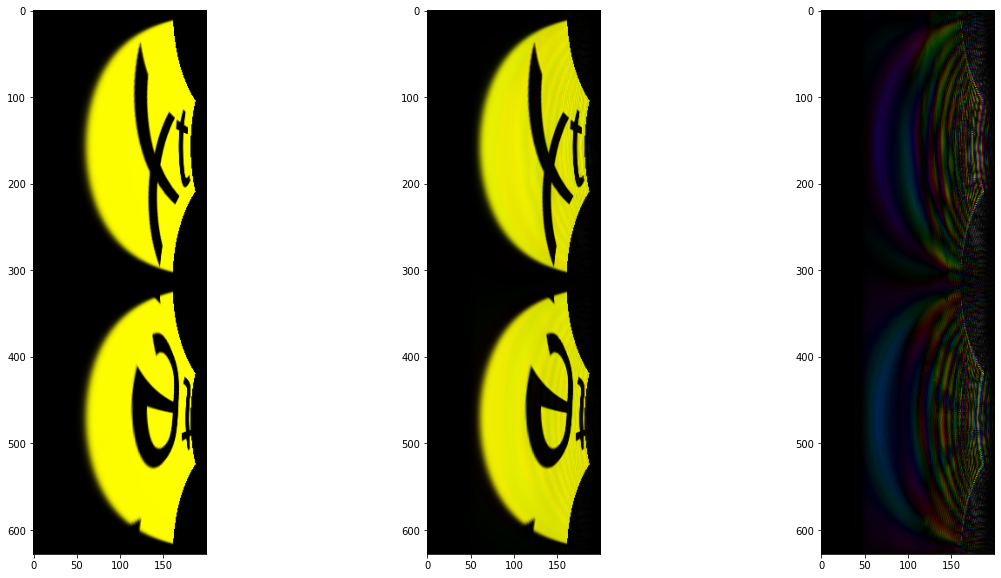

In [8]:
text = ECTEvaluator("../sample_imgs/text.png")

text.eval(snr)
text.eval(snr_abs)
text.show(rmsnorm)

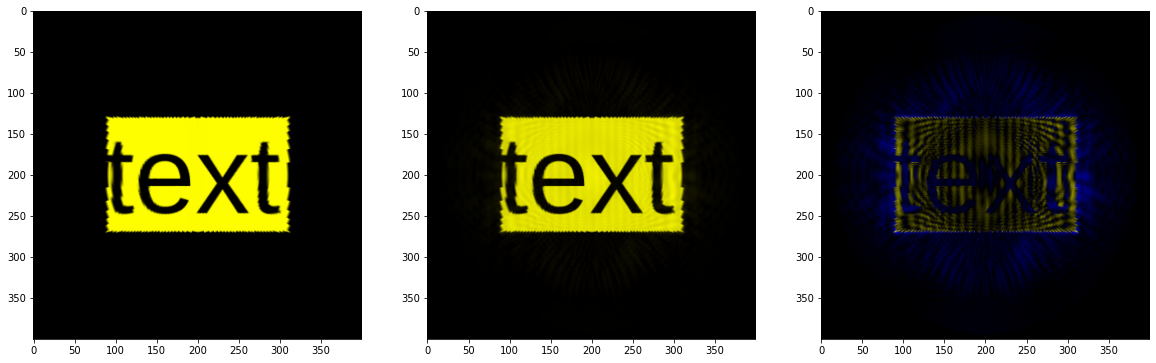

In [9]:
text.show_cart(absnorm)

snr = 28.30+0.00j
snr_abs = 29.08


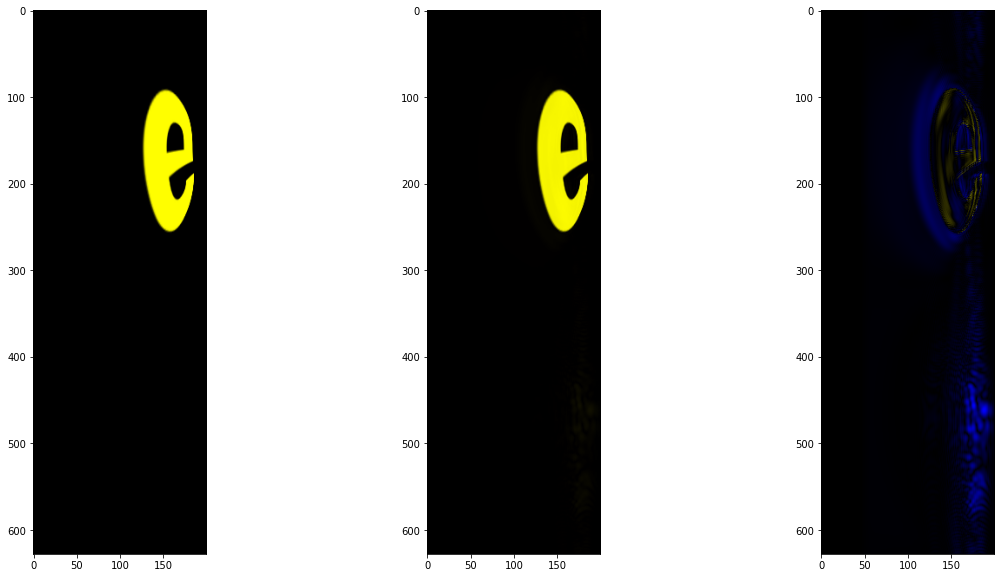

In [10]:
blacke = ECTEvaluator("../sample_imgs/black_e.png")

blacke.eval(snr)
blacke.eval(snr_abs)
blacke.show(absnorm)

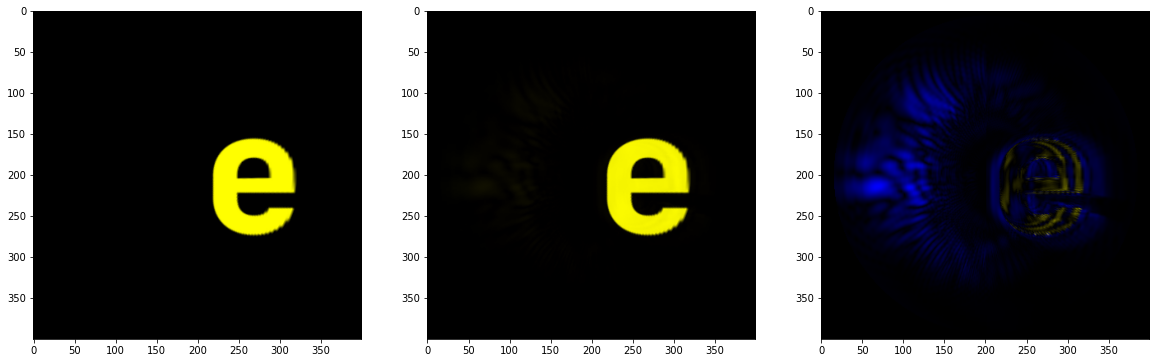

In [11]:
blacke.show_cart(absnorm)

snr = 24.03+0.00j
snr_abs = 26.60


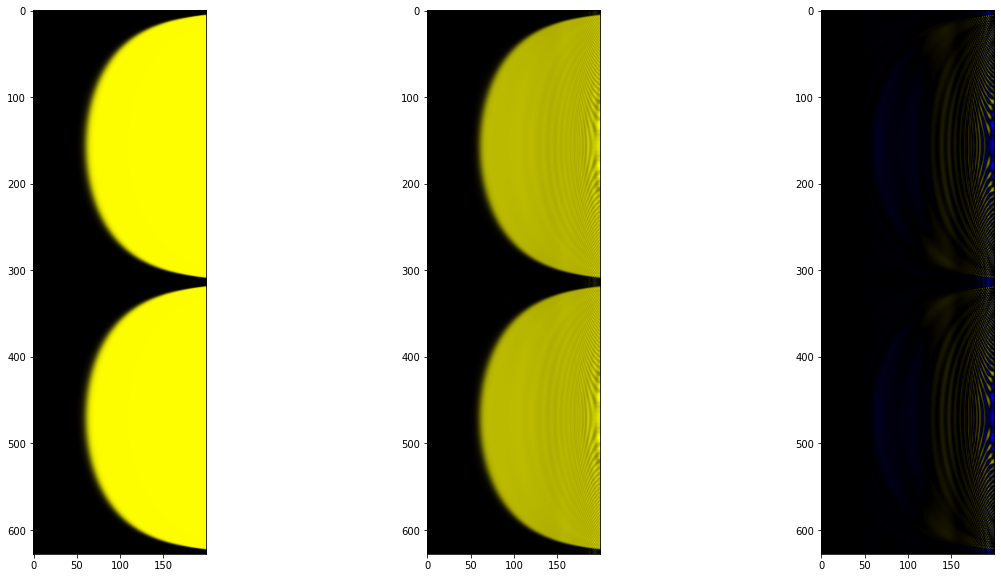

In [12]:
wedge = ECTEvaluator("../sample_imgs/white.png")

wedge.eval(snr)
wedge.eval(snr_abs)
wedge.show(absnorm)

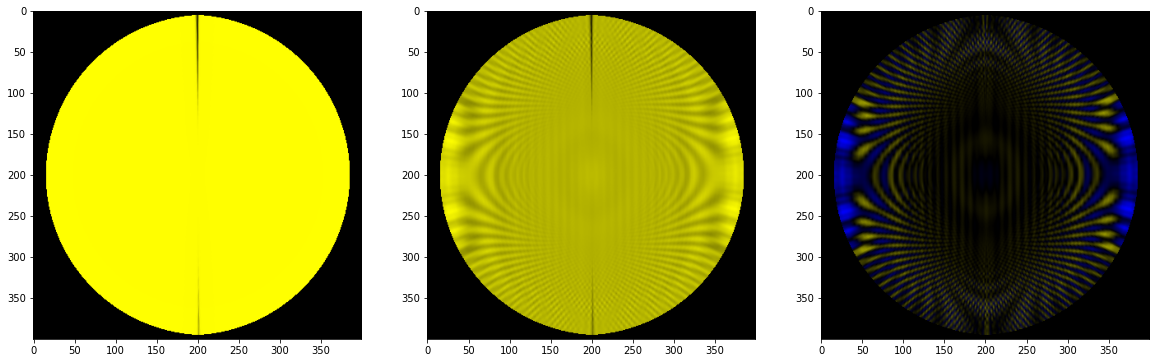

In [13]:
wedge.show_cart(absnorm)

snr = 18.80+0.00j
snr_abs = 20.84


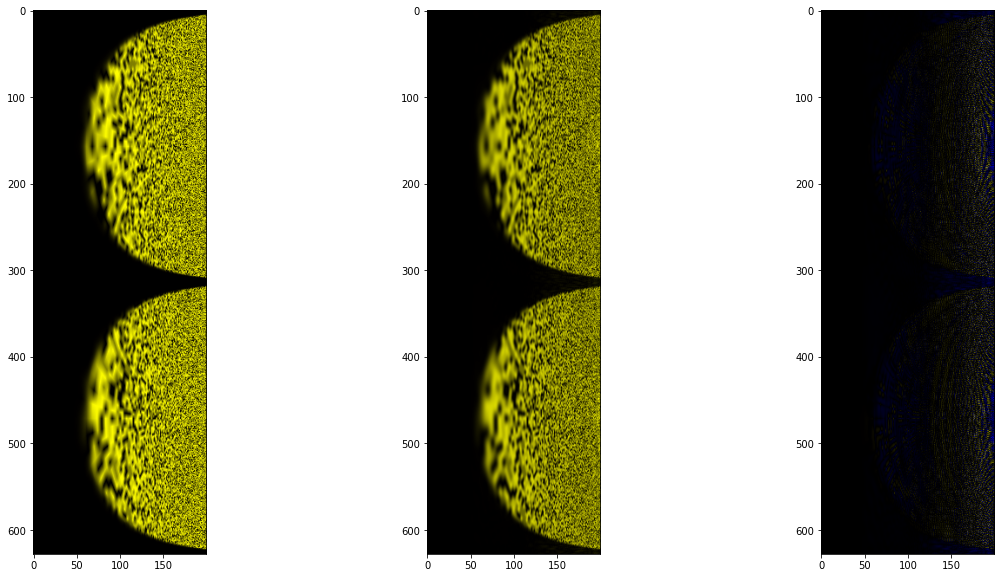

In [14]:
wnoise = ECTEvaluator("../sample_imgs/whitenoise.png")

wnoise.eval(snr)
wnoise.eval(snr_abs)
wnoise.show(absnorm)

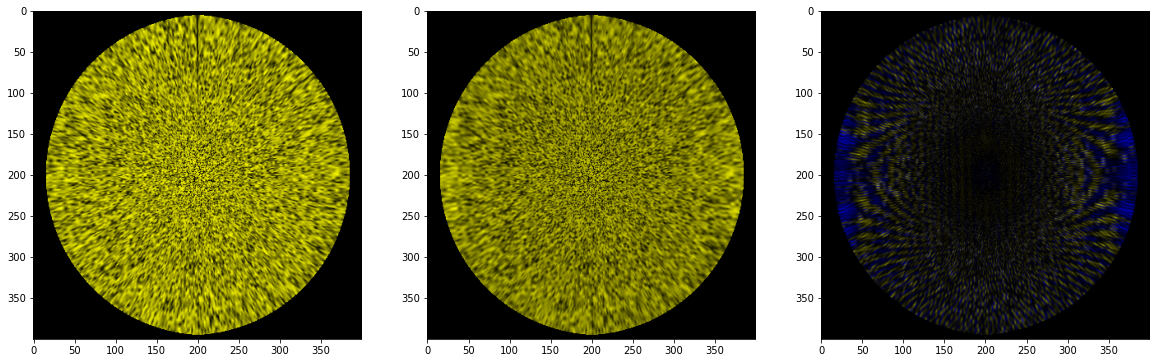

In [15]:
wnoise.show_cart(absnorm)